In [ ]:
!pip install imbalanced-learn catboost xgboost lightgbm shap lime scikit-plot


In [ ]:
!pip install feyn  alibi


In [ ]:
import numpy
import scipy
import sklearn
import imblearn
import shap
import lime
import feyn
import alibi


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving alzheimers_disease_data.csv to alzheimers_disease_data.csv


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('alzheimers_disease_data.csv')
df = df.drop(columns=['PatientID', 'DoctorInCharge'])

X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
from imblearn.over_sampling import SMOTE, SVMSMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTEENN

balancers = {
    'SMOTE': SMOTE(random_state=42),
    'SVMSMOTE': SVMSMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'BorderlineSMOTE': BorderlineSMOTE(random_state=42),

}


In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier

models = {
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    'CatBoost': CatBoostClassifier(verbose=0),
    'RandomForest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
}


In [ ]:
from sklearn.metrics import roc_auc_score

best_models = {}
results = []

for model_name, model in models.items():
    best_score = 0
    best_balancer = None
    best_model = None
    for balancer_name, balancer in balancers.items():
        X_res, y_res = balancer.fit_resample(X_train, y_train)
        model.fit(X_res, y_res)
        y_pred = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        results.append((model_name, balancer_name, auc))
        if auc > best_score:
            best_score = auc
            best_balancer = balancer_name
            best_model = model
    best_models[model_name] = (best_model, best_balancer, best_score)

# Display results
results_df = pd.DataFrame(results, columns=['Model', 'Balancer', 'AUC']).sort_values(by='AUC', ascending=False)
results_df.head()


Model         Balancer       AUC
19  CatBoost  BorderlineSMOTE  0.944813
16  CatBoost            SMOTE  0.943629
18  CatBoost           ADASYN  0.943416
17  CatBoost         SVMSMOTE  0.943180
15   XGBoost  BorderlineSMOTE  0.941996

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

best_models = {}
results = []

for model_name, model in models.items():
    best_score = 0
    best_balancer = None
    best_model = None
    for balancer_name, balancer in balancers.items():
        X_res, y_res = balancer.fit_resample(X_train, y_train)
        model.fit(X_res, y_res)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test) # Get class predictions for other metrics

        auc = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)


        results.append((model_name, balancer_name, accuracy, precision, recall, f1, auc))

        if auc > best_score:
            best_score = auc
            best_balancer = balancer_name
            best_model = model

    best_models[model_name] = (best_model, best_balancer, best_score)

# Display results
results_df = pd.DataFrame(results, columns=['Model', 'Balancer', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']).sort_values(by='AUC', ascending=False)
print("Model Performance with Different Balancers:")
display(results_df)

Model Performance with Different Balancers:


Model         Balancer  Accuracy  Precision    Recall  \
19            CatBoost  BorderlineSMOTE  0.939535   0.909091  0.921053   
20        RandomForest            SMOTE  0.911628   0.895833  0.848684   
16            CatBoost            SMOTE  0.944186   0.915584  0.927632   
18            CatBoost           ADASYN  0.944186   0.915584  0.927632   
17            CatBoost         SVMSMOTE  0.948837   0.927632  0.927632   
15             XGBoost  BorderlineSMOTE  0.934884   0.907895  0.907895   
12             XGBoost            SMOTE  0.934884   0.913333  0.901316   
14             XGBoost           ADASYN  0.927907   0.885350  0.914474   
21        RandomForest         SVMSMOTE  0.939535   0.931507  0.894737   
22        RandomForest           ADASYN  0.918605   0.903448  0.861842   
13             XGBoost         SVMSMOTE  0.934884   0.913333  0.901316   
26            AdaBoost           ADASYN  0.860465   0.744681  0.921053   
25            AdaBoost         SVMSMOTE  0.909302   0.838323  0.921053   
27            AdaBoost  BorderlineSMOTE  0.872093   0.765027  0.921053   
23        RandomForest  BorderlineSMOTE  0.904651   0.877551  0.848684   
24            AdaBoost            SMOTE  0.876744   0.776536  0.914474   
9   LogisticRegression         SVMSMOTE  0.790698   0.670330  0.802632   
11  LogisticRegression  BorderlineSMOTE  0.781395   0.659341  0.789474   
10  LogisticRegression           ADASYN  0.783721   0.661202  0.796053   
8   LogisticRegression            SMOTE  0.793023   0.682081  0.776316   
2                  SVM           ADASYN  0.567442   0.435606  0.756579   
0                  SVM            SMOTE  0.586047   0.437500  0.598684   
3                  SVM  BorderlineSMOTE  0.602326   0.448649  0.546053   
1                  SVM         SVMSMOTE  0.567442   0.409574  0.506579   
6                  KNN           ADASYN  0.504651   0.378486  0.625000   
4                  KNN            SMOTE  0.506977   0.375000  0.592105   
7                  KNN  BorderlineSMOTE  0.502326   0.369748  0.578947   
5                  KNN         SVMSMOTE  0.520930   0.368932  0.500000   

    F1 Score       AUC  
19  0.915033  0.944813  
20  0.871622  0.943748  
16  0.921569  0.943629  
18  0.921569  0.943416  
17  0.927632  0.943180  
15  0.907895  0.941996  
12  0.907285  0.940600  
14  0.899676  0.937879  
21  0.912752  0.937488  
22  0.882155  0.936471  
13  0.907285  0.936411  
26  0.823529  0.936269  
25  0.877743  0.935015  
27  0.835821  0.934814  
23  0.862876  0.933749  
24  0.839879  0.931122  
9   0.730539  0.874905  
11  0.718563  0.868989  
10  0.722388  0.868610  
8   0.726154  0.867853  
2   0.552885  0.642465  
0   0.505556  0.638111  
3   0.492582  0.628881  
1   0.452941  0.591466  
6   0.471464  0.548869  
4   0.459184  0.529700  
7   0.451282  0.521583  
5   0.424581  0.508366

In [ ]:
from sklearn.ensemble import StackingClassifier, VotingClassifier

# Prepare base learners
stack_estimators = [(name, model[0]) for name, model in best_models.items()]

# Meta learner
meta_learner = LogisticRegression()

# Stack classifier
stack_model = StackingClassifier(estimators=stack_estimators, final_estimator=meta_learner, passthrough=True)
stack_model.fit(X_train, y_train)

# Soft Voting
soft_vote_model = VotingClassifier(estimators=stack_estimators, voting='soft')
soft_vote_model.fit(X_train, y_train)

# Hard Voting
hard_vote_model = VotingClassifier(estimators=stack_estimators, voting='hard')
hard_vote_model.fit(X_train, y_train)


VotingClassifier(estimators=[('SVM', SVC(probability=True)),
                             ('KNN', KNeighborsClassifier()),
                             ('LogisticRegression',
                              LogisticRegression(max_iter=1000)),
                             ('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eva...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('CatBoost',
                              <catboost.core.CatBoostClassifier object at 0x7c72b1cb9f90>),
                             ('RandomForest', RandomForestClassifier()),
                             ('AdaBoost', AdaBoostClassifier())])

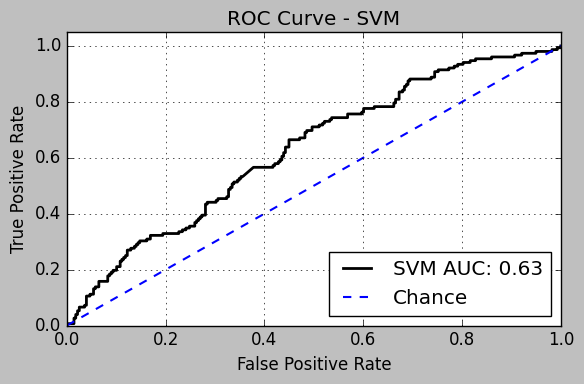

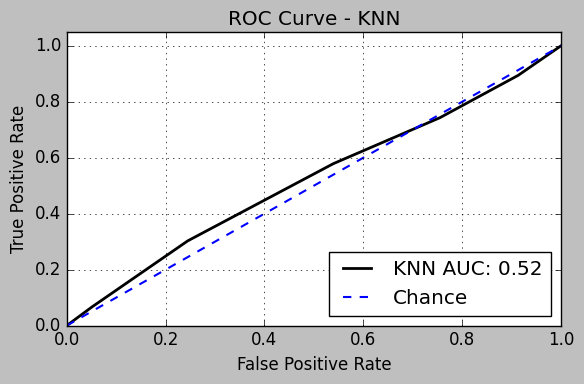

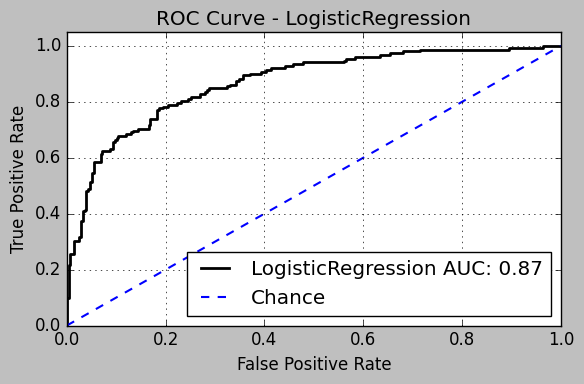

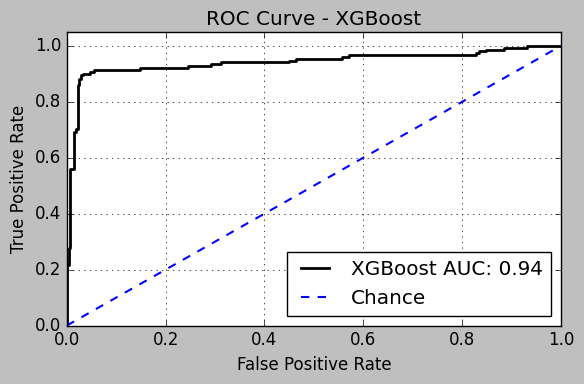

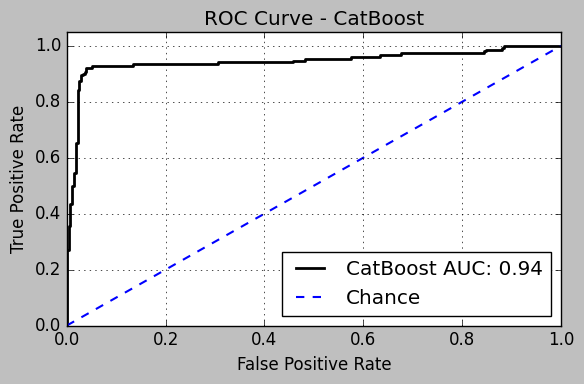

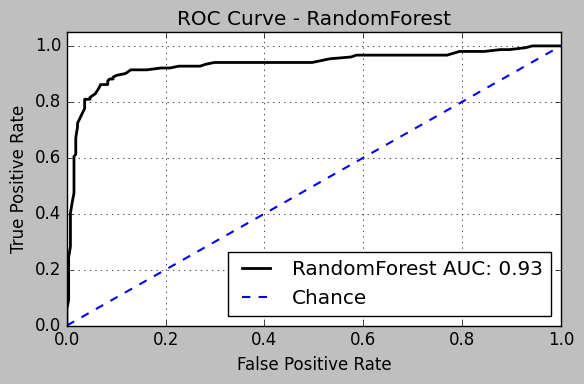

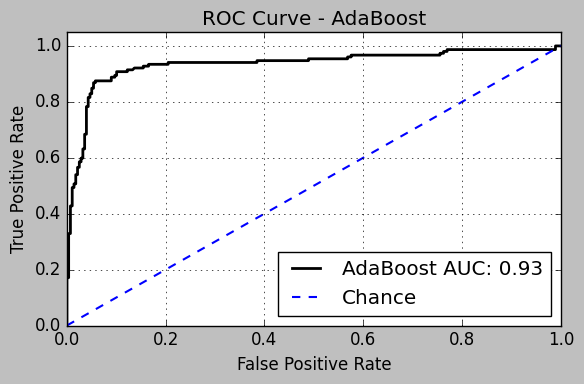

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.style.use('classic')

for name, (model, _, _) in best_models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4), dpi=100)
    plt.plot(fpr, tpr, color='black', lw=2, label=f'{name} AUC: {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'b--', lw=1.5, label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

# Predict probabilities for ROC AUC (except hard voting, which uses predict)
stack_auc = roc_auc_score(y_test, stack_model.predict_proba(X_test)[:, 1])
soft_auc = roc_auc_score(y_test, soft_vote_model.predict_proba(X_test)[:, 1])
# For hard vote, use predict since it doesn’t support predict_proba
hard_auc = roc_auc_score(y_test, hard_vote_model.predict(X_test))

# Print AUCs
print(f"Stacking AUC: {stack_auc:.4f}")
print(f"Soft Voting AUC: {soft_auc:.4f}")
print(f"Hard Voting AUC: {hard_auc:.4f}")

# Identify best
best_auc = max(stack_auc, soft_auc, hard_auc)
if best_auc == stack_auc:
    alzstackapp = stack_model
    best_name = "Stacking"
elif best_auc == soft_auc:
    alzstackapp = soft_vote_model
    best_name = "Soft Voting"
else:
    alzstackapp = hard_vote_model
    best_name = "Hard Voting"

print(f"\n✅ Best Ensemble = {best_name} → Assigned as `alzstackapp`")


Stacking AUC: 0.9407
Soft Voting AUC: 0.9456
Hard Voting AUC: 0.9231

✅ Best Ensemble = Soft Voting → Assigned as `alzstackapp`


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

ensemble_results = []

# Stacking Classifier
stack_pred_proba = stack_model.predict_proba(X_test)[:, 1]
stack_pred = stack_model.predict(X_test)
ensemble_results.append({
    'Model': 'Stacking',
    'Accuracy': accuracy_score(y_test, stack_pred),
    'Precision': precision_score(y_test, stack_pred),
    'Recall': recall_score(y_test, stack_pred),
    'F1 Score': f1_score(y_test, stack_pred),
    'AUC': roc_auc_score(y_test, stack_pred_proba)
})

# Soft Voting Classifier
soft_vote_pred_proba = soft_vote_model.predict_proba(X_test)[:, 1]
soft_vote_pred = soft_vote_model.predict(X_test)
ensemble_results.append({
    'Model': 'Soft Voting',
    'Accuracy': accuracy_score(y_test, soft_vote_pred),
    'Precision': precision_score(y_test, soft_vote_pred),
    'Recall': recall_score(y_test, soft_vote_pred),
    'F1 Score': f1_score(y_test, soft_vote_pred),
    'AUC': roc_auc_score(y_test, soft_vote_pred_proba)
})

# Hard Voting Classifier
hard_vote_pred = hard_vote_model.predict(X_test)
ensemble_results.append({
    'Model': 'Hard Voting',
    'Accuracy': accuracy_score(y_test, hard_vote_pred),
    'Precision': precision_score(y_test, hard_vote_pred),
    'Recall': recall_score(y_test, hard_vote_pred),
    'F1 Score': f1_score(y_test, hard_vote_pred),
    # AUC for hard voting is calculated differently, typically using predicted labels
    'AUC': roc_auc_score(y_test, hard_vote_pred)
})

# Display results
ensemble_results_df = pd.DataFrame(ensemble_results).sort_values(by='AUC', ascending=False)
print("\nEnsemble Model Performance:")
display(ensemble_results_df)


Ensemble Model Performance:


Model  Accuracy  Precision    Recall  F1 Score       AUC
1  Soft Voting  0.939535   0.937500  0.888158  0.912162  0.945570
0     Stacking  0.941860   0.920530  0.914474  0.917492  0.940718
2  Hard Voting  0.937209   0.943262  0.875000  0.907850  0.923112

In [ ]:
# Assuming X_test is your test data
sample = X_test.iloc[:1]  # use [:1] for a batch of 1, or replace with any batch slice

print("Predicted probabilities from each base model:\n")
for name, model in models.items():
    try:
        probs = model.predict_proba(sample)
        print(f"{name}: {probs}")
    except Exception as e:
        print(f"{name}: Error - {e}")


Predicted probabilities from each base model:

SVM: [[0.27072777 0.72927223]]
KNN: [[0. 1.]]
LogisticRegression: [[0.28815281 0.71184719]]
XGBoost: [[9.3501806e-04 9.9906498e-01]]
CatBoost: [[0.04878923 0.95121077]]
RandomForest: [[0.18 0.82]]
AdaBoost: [[0.43491664 0.56508336]]


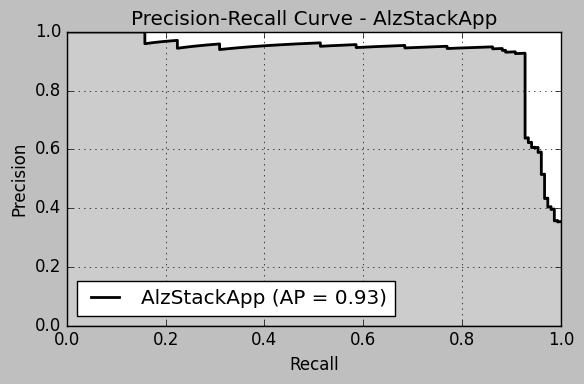

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get predicted probabilities (or predicted class for hard voting)
if hasattr(alzstackapp, "predict_proba"):
    y_scores = alzstackapp.predict_proba(X_test)[:, 1]
else:
    # fallback: use predicted labels for models without probas (not ideal for PR)
    y_scores = alzstackapp.predict(X_test)

precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

plt.style.use('classic')
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(recall, precision, color='black', lw=2, label=f'AlzStackApp (AP = {avg_precision:.2f})')
plt.fill_between(recall, precision, alpha=0.2, color='black')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - AlzStackApp')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 1. Recover column names
feature_names = X.columns.tolist()

# 2. Rebuild X_test as DataFrame with feature names
import numpy as np
X_test_named = pd.DataFrame(X_test, columns=feature_names)



PermutationExplainer explainer: 431it [31:57,  4.47s/it]


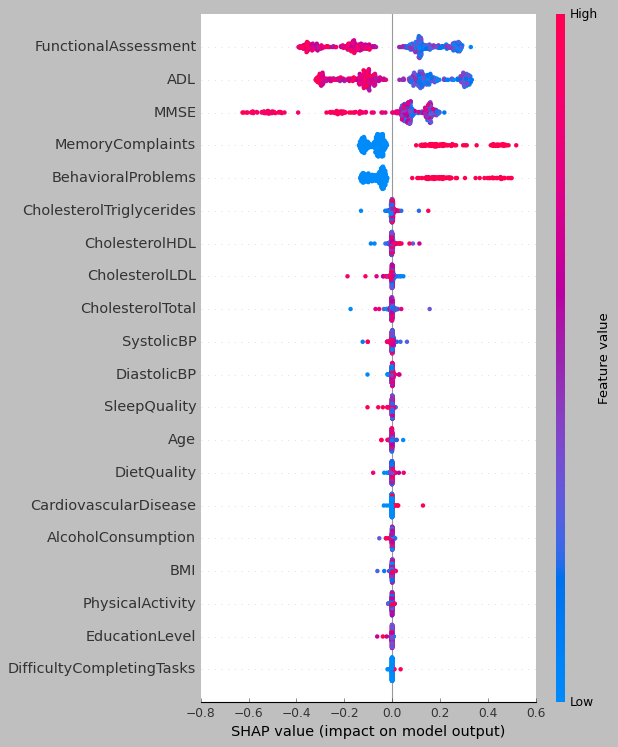

In [ ]:
import shap

# SHAP requires a model with predict_proba
if hasattr(alzstackapp, "predict_proba"):
    explainer = shap.Explainer(alzstackapp.predict, X_test_named)
    shap_values = explainer(X_test_named)

    # Summary Plot
    shap.summary_plot(shap_values, X_test_named)
else:
    print("SHAP requires a model with predict_proba. Not supported for hard voting.")


In [ ]:
import lime
import lime.lime_tabular
# [Keep all original imports and code up to ensemble training unchanged]

# ============== Added: LIME for Specific Cases ==============
# Find actual negative/positive cases in test set
negative_case = X_test[y_test == 0].iloc[0]
positive_case = X_test[y_test == 1].iloc[0]

# Initialize LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=['No AD', 'AD'],
    mode='classification'
)

# Explain negative diagnosis
exp_neg = lime_explainer.explain_instance(
    negative_case.values,
    alzstackapp.predict_proba,
    num_features=15
)
print("\nLIME Explanation for Alzheimer's NEGATIVE Diagnosis:")
exp_neg.show_in_notebook()

# Explain positive diagnosis
exp_pos = lime_explainer.explain_instance(
    positive_case.values,
    alzstackapp.predict_proba,
    num_features=15
)
print("\nLIME Explanation for Alzheimer's POSITIVE Diagnosis:")
exp_pos.show_in_notebook()



LIME Explanation for Alzheimer's NEGATIVE Diagnosis:



LIME Explanation for Alzheimer's POSITIVE Diagnosis:


In [ ]:
pip install lime

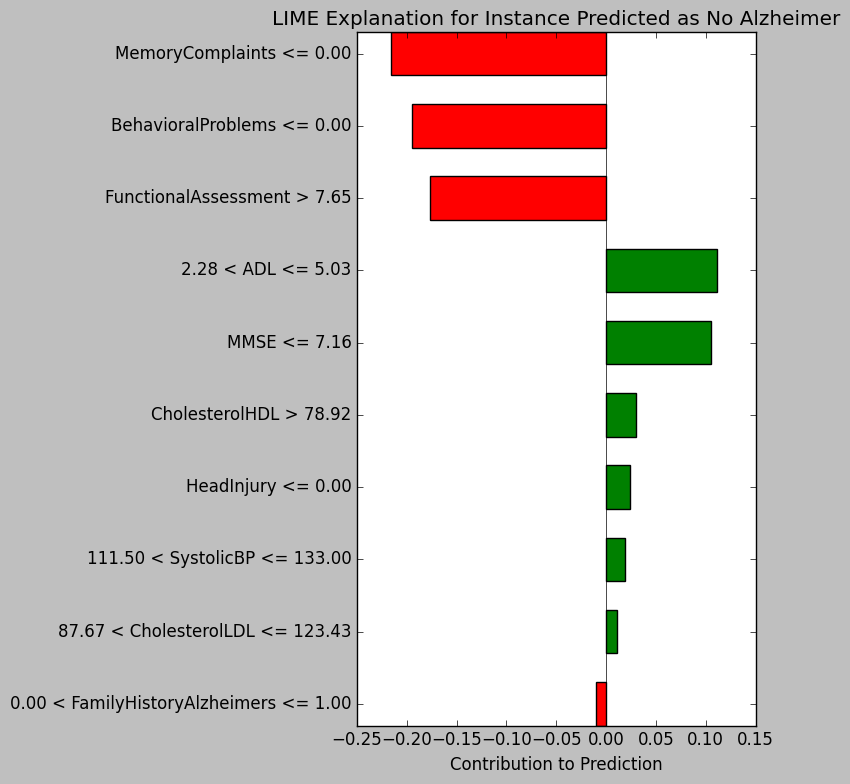

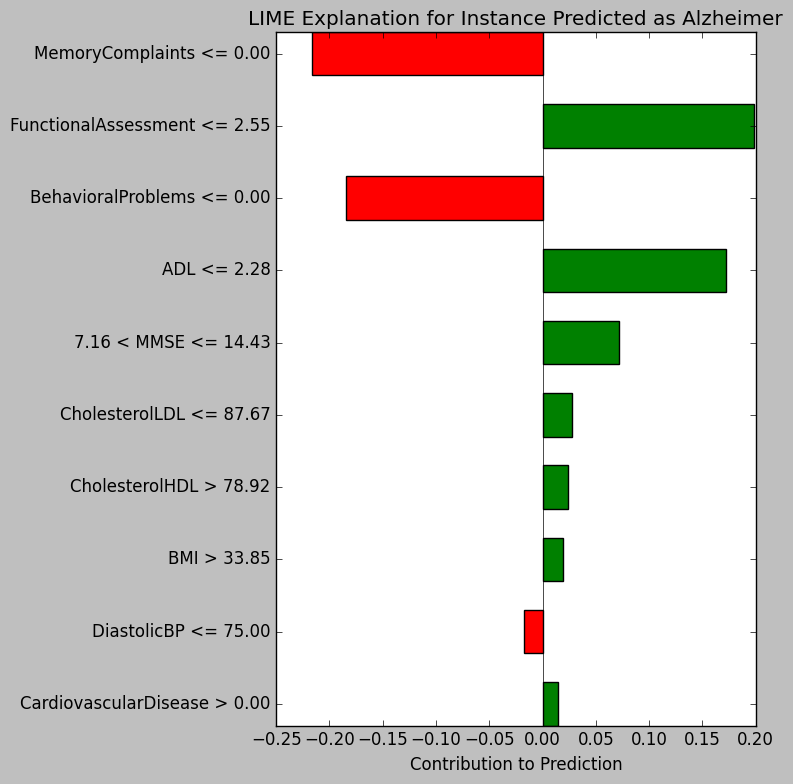

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import lime
import lime.lime_tabular
import pandas as pd # Ensure pandas is imported if needed elsewhere

# Re-initialize the LIME explainer here to ensure it's defined when the function is used
# This assumes X_train and X are already defined from previous cells
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=['No AD', 'AD'],
    mode='classification'
)

# Function to generate labeled LIME plots
def plot_lime_explanation(instance_index, label_text):
    # Get LIME explanation
    exp = lime_explainer.explain_instance(
        data_row=X_test_named.iloc[instance_index],
        predict_fn=alzstackapp.predict_proba,
        num_features=10
    )

    # Check which class explanations are available
    available_classes = exp.local_exp.keys()

    if not available_classes:
        print(f"No LIME explanation available for instance {instance_index}.")
        return

    # Iterate through available classes and plot
    for class_label in available_classes:
        # Extract feature impact values for the current class
        # Ensure the class_label exists in the explanation object before accessing
        if class_label in exp.local_exp:
            lime_fig = exp.as_list(label=class_label)
            features, weights = zip(*lime_fig)
            colors = ['green' if w > 0 else 'red' for w in weights]

            # Get the class name for the title
            class_name = lime_explainer.class_names[class_label]

            # Plot
            plt.figure(figsize=(8, 8), dpi=100) # Keep increased figure height for overall space
            # DECREASE BAR HEIGHT HERE (e.g., from default 0.8 to 0.6 or 0.5)
            plt.barh(features, weights, color=colors, height=0.6) # Added height parameter
            plt.xlabel("Contribution to Prediction")
            plt.title(f"LIME Explanation for {label_text}")
            plt.axvline(0, color='black', linewidth=0.5)
            plt.tight_layout()
            plt.gca().invert_yaxis()
            plt.show()
        else:
             print(f"Error: Class label {class_label} not found in explanation data for instance {instance_index}.")


# Automatically choose samples from each predicted class
# Ensure X_test_named is defined from a previous cell
# Make sure X_test_named is indeed a pandas DataFrame
# if it was created in a previous cell, it should be.
preds = alzstackapp.predict(X_test_named)

# Ensure that there is at least one prediction for each class before trying to get the index
if 0 in preds:
    idx_negative = np.where(preds == 0)[0][0]
    # (a) Alzheimer’s Negative Prediction - Pass only the index and text label
    plot_lime_explanation(idx_negative, "Instance Predicted as No Alzheimer")
else:
    print("No instances predicted as negative (Class 0) in the test set.")

if 1 in preds:
    idx_positive = np.where(preds == 1)[0][0]
    # (b) Alzheimer’s Positive Prediction - Pass only the index and text label
    plot_lime_explanation(idx_positive, "Instance Predicted as Alzheimer")
else:
    print("No instances predicted as positive (Class 1) in the test set.")

In [ ]:
|# ================== Working Anchor Explanations ==================
from alibi.explainers import AnchorTabular

def apply_anchor(model, model_name, instance_idx=0):
    try:
        # Initialize explainer with training data
        explainer = AnchorTabular(
            predictor=model.predict,
            feature_names=X.columns.tolist()
        )
        explainer.fit(X_train.values)

        # Get test instance
        instance = X_test.iloc[instance_idx].values.reshape(1, -1)

        # Generate explanation
        explanation = explainer.explain(instance, threshold=0.95)

        # Parse and print rules
        if hasattr(explanation, 'anchor'):
            print(f"\n🔍 Anchor Explanation for {model_name} (Instance {instance_idx}):")
            print(f"Predicted class: {model.predict(instance)[0]}")
            print("Decision rules:")
            for rule in explanation.anchor:
                print(f"- {rule}")
            print(f"Precision: {explanation.precision:.2f}, Coverage: {explanation.coverage:.2f}")
        else:
            print("No anchor rules generated for this instance.")

    except Exception as e:
        print(f"❌ Anchor Error: {str(e)}")

# Run anchor explanations
apply_anchor(alzstackapp, "FinalEnsemble", 0)
apply_anchor(alzstackapp, "FinalEnsemble", 1)





🔍 Anchor Explanation for FinalEnsemble (Instance 0):
Predicted class: 1
Decision rules:
- FunctionalAssessment <= 2.55
- ADL <= 2.28
- MMSE <= 22.15
Precision: 0.99, Coverage: 0.05

🔍 Anchor Explanation for FinalEnsemble (Instance 1):
Predicted class: 0
Decision rules:
- FunctionalAssessment > 7.65
- MemoryComplaints <= 0.00
Precision: 0.96, Coverage: 0.19


In [ ]:
from feyn import QLattice
import matplotlib.pyplot as plt

import pandas as pd
df = pd.read_csv("alzheimers_disease_data.csv")
df = df.drop(['DoctorInCharge'], axis=1, errors='ignore')

input_names = df.columns[:-1].tolist()
output_name = df.columns[-1]

qlattice = QLattice()

qgraph = qlattice.sample_models(input_names, output_name)

best_models = qgraph[:5]

for i, model in enumerate(best_models, 1):
    print(f"Model {i}: {model}")


Model 1: <feyn._model.Model object at 0x7f29420a7b90>
Model 2: <feyn._model.Model object at 0x7f2941f35110>
Model 3: <feyn._model.Model object at 0x7f2941f37b10>
Model 4: <feyn._model.Model object at 0x7f2941f37f90>
Model 5: <feyn._model.Model object at 0x7f2941f5d790>


<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="216.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 531 216.0" width="531" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="351" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="241" y="50.0"><title>Diagnosis
linear:
scale=1.000000
scale offset=0.000000
w=-1.754039
bias=0.0000</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="71.5">Diagnosis</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="243" y="59.0">linear</text><line stroke="#1E1E1E" x1="211" x2="241" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="50.0"><title>gaussian</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="71.5">gaussian</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="59.0">1</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="76.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>FamilyHistoryAlzheimers
linear:
scale=1.000000
scale offset=0.000000
w=-1.265401
bias=-1.6438</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">FamilyHi..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>BehavioralProblems
linear:
scale=1.000000
scale offset=0.000000
w=1.361073
bias=0.8751</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">Behavior..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">3</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">num</text></svg><svg class="summary" height="64" width="180" x="351" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="0" y="14">Training Metrics</text><line stroke="#1E1E1E" x1="0" x2="160" y1="19" y2="19" /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="34">R2</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="34">-0.55</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="49">RMSE</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="49">0.595</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="64">MAE</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="64">0.355</text></svg><svg class="h_space" height="19" width="50" x="0" y="155.0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="0" y="14">Inputs</text><line stroke="#1E1E1E" x1="0" x2="50" y1="19" y2="19" /></svg><svg class="table" height="37" width="186" x="0" y="174.0"><defs 
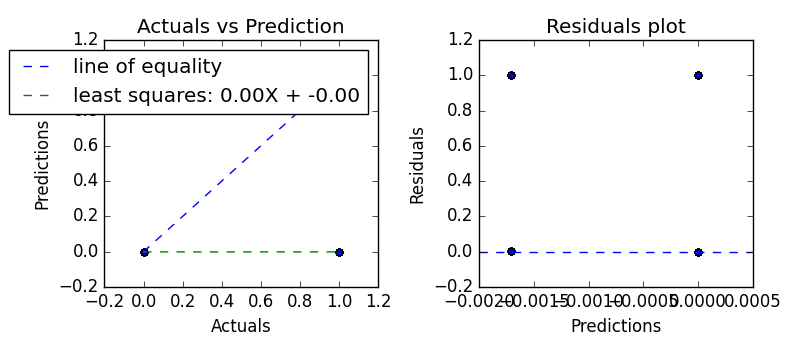

In [ ]:
best_model = best_models[0]
best_model.plot(df)

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="216.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 531 216.0" width="531" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="351" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="241" y="50.0"><title>Diagnosis
linear:
scale=1.000000
scale offset=0.000000
w=-1.298167
bias=0.0000</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="71.5">Diagnosis</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="243" y="59.0">linear</text><line stroke="#1E1E1E" x1="211" x2="241" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="50.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="71.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="59.0">1</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="76.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>DietQuality
linear:
scale=1.000000
scale offset=0.000000
w=1.576967
bias=-0.4041</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">DietQual..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>Disorientation
linear:
scale=1.000000
scale offset=0.000000
w=1.462347
bias=-0.9105</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">Disorien..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">3</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">num</text></svg><svg class="summary" height="64" width="180" x="351" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="0" y="14">Training Metrics</text><line stroke="#1E1E1E" x1="0" x2="160" y1="19" y2="19" /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="34">R2</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="34">-5.24e+02</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="49">RMSE</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="49">11.0</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="64">MAE</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="64">9.25</text></svg><svg class="h_space" height="19" width="50" x="0" y="155.0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="0" y="14">Inputs</text><line stroke="#1E1E1E" x1="0" x2="50" y1="19" y2="19" /></svg><svg class="table" height="37" width="121" x="0" y="174.0"><defs /><text fill="#1E1E1E" f
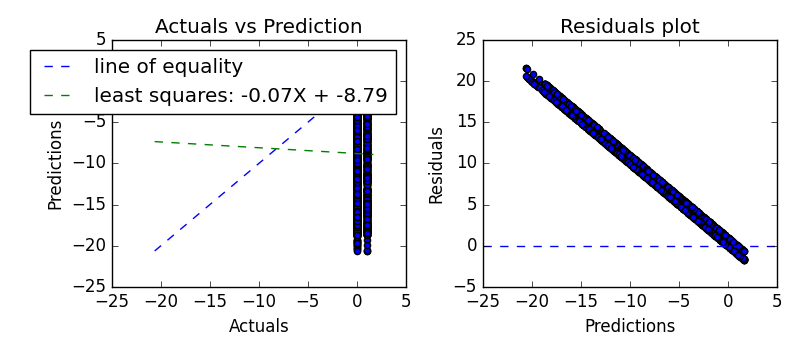

In [ ]:
best_model = best_models[1]
best_model.plot(df)